
Computing Error-Bars to estimate the effect of randomly initialised parameters 
==

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import folie as fl
from copy import deepcopy

This notebook runs a simulation once to generate data, then for each estimator run 3 different estimations starting from different coefficients $ \sim \mathcal{N}(\mu,\sigma^2)$  
Choose your Hyper-parameters $\mu$ and $\sigma$

In [2]:
mu = 3
sigma = 1
M = 3 # number of differnt estimation for a given estimator and given data
np.random.seed(3)

## Generate data

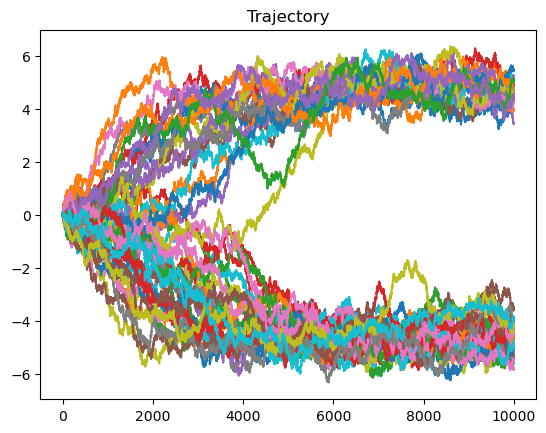

In [3]:
coeff = 0.2 * np.array([0, 0, -4.5, 0, 0.1])
free_energy = np.polynomial.Polynomial(coeff)
D = 0.5
force_coeff = D * np.array([-coeff[1], -2 * coeff[2], -3 * coeff[3], -4 * coeff[4]])

force_function = fl.functions.Polynomial(deg=3, coefficients=force_coeff)
diff_function = fl.functions.Polynomial(deg=0, coefficients=np.array(D))

# Plot of Free Energy and Force
x_values = np.linspace(-7, 7, 100)

# Define model to simulate and type of simulator to use
dt = 1e-3
model_simu = fl.models.overdamped.Overdamped(force_function, diffusion=diff_function)
simulator = fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt)


# initialize positions
ntraj = 50
q0 = np.empty(ntraj)
for i in range(len(q0)):
    q0[i] = 0
# Calculate Trajectory
time_steps = 10000
data = simulator.run(time_steps, q0, save_every=1)

# Plot resulting Trajectories
fig, axs = plt.subplots()
for n, trj in enumerate(data):
    axs.plot(trj["x"])
    axs.set_title("Trajectory")


## Training


### Euler Training 

In [4]:
fig, axs = plt.subplots(1, 2,figsize=(8,5.5))
fig, axf = plt.subplots(figsize=(8,5.5))
np.random.seed(3)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()
axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 75)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)),color='r', label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), color='r',label="Exact")

nknots=4
domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min, data.stats.max, nknots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=None)

Euler_res=[]
Euler_fes=[]
markers=['1','2','3']
for index in range(M):
    coefficients0= np.random.normal(loc=mu, scale=sigma, size=2*nknots)
    print('random',coefficients0)
    estimator = fl.LikelihoodEstimator(fl.EulerDensity(trainmodel) ,n_jobs=4)
    Euler_res.append(estimator.fit_fetch(data,coefficients0=coefficients0))
    print('Euler',index +1,Euler_res[index].coefficients)
    axs[0].scatter(xfa, Euler_res[index].force(xfa.reshape(-1, 1)), marker=markers[index], label='Euler'+str(index+1))
    axs[1].scatter(xfa, Euler_res[index].diffusion(xfa.reshape(-1, 1)), marker=markers[index], label='Euler'+str(index+1))
    Euler_fes.append(fl.analysis.free_energy_profile_1d(Euler_res[index],xfa))
    axf.plot(xfa,Euler_fes[index])

Euler_res0=fl.LikelihoodEstimator(fl.EulerDensity(trainmodel) ,n_jobs=4).fit_fetch(data)
print('Euler KM',Euler_res0.coefficients)
axs[0].scatter(xfa, Euler_res0.force(xfa.reshape(-1, 1)),color = 'grey', marker='x', label='EulerKM')
axs[1].scatter(xfa, Euler_res0.diffusion(xfa.reshape(-1, 1)), color = 'grey',marker='x', label='EulerKM')

axs[0].legend()
axs[1].legend()


random [2.7226118  2.64524102 2.91725852 2.37299932 2.95618183 2.52278197
 1.68613525 3.88462238]


/home/dbersano/folie/folie/estimation/transitionDensity.py:20: RuntimeWarning: invalid value encountered in log
  ll = -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:20: RuntimeWarning: invalid value encountered in log
  ll = -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:20: RuntimeWarning: invalid value encountered in log
  ll = -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:20: RuntimeWarning: invalid value encountered in log
  ll = -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)


Euler 1 [  4.26604296 -11.42518271  11.1839546   -3.97643622   0.50641358
   0.48436748   0.50919854   0.49611813]
random [3.88131804 4.70957306 3.05003364 2.59532259 2.45464005 1.45352268
 3.98236743 1.89893237]
Euler 2 [  4.26607639 -11.42829019  11.17660047  -3.97111746   0.50624366
   0.4847656    0.50902849   0.49613225]
random [1.81495347 2.7943501  4.48614836 3.23671627 1.97621486 2.2870068
 3.62524497 2.83948664]


#### estimate errorbars

[0.21449454 0.15412427 0.10789402 0.07493673 0.05464772 0.04521289
 0.04208893 0.04031015 0.03707123 0.03138766 0.02314267 0.01256394
 0.         0.01417228 0.02958612 0.04590027 0.06280422 0.08001873
 0.09729425 0.11440844 0.13116344 0.14738329 0.16291156 0.17760933
 0.19135361 0.20403621 0.21556296 0.22585353 0.23484152 0.24247513
 0.24871824 0.253552   0.25697688 0.25901533 0.25971496 0.25915233
 0.25743733 0.25471802 0.25118564 0.24707924 0.24268882 0.23835515
 0.23446391 0.23143087 0.22967576 0.22958462 0.23146481 0.23550205
 0.24173091 0.25002705 0.26012183 0.27163225 0.28409615 0.2970048
 0.30982862 0.32203603 0.33310713 0.34254477 0.34988579 0.35471483
 0.35668373 0.3555404  0.35117265 0.34367576 0.33345689 0.32139291
 0.30905349 0.29896065 0.29473193 0.30075686 0.32111056 0.35818357
 0.41219477 0.48187473 0.56542106]


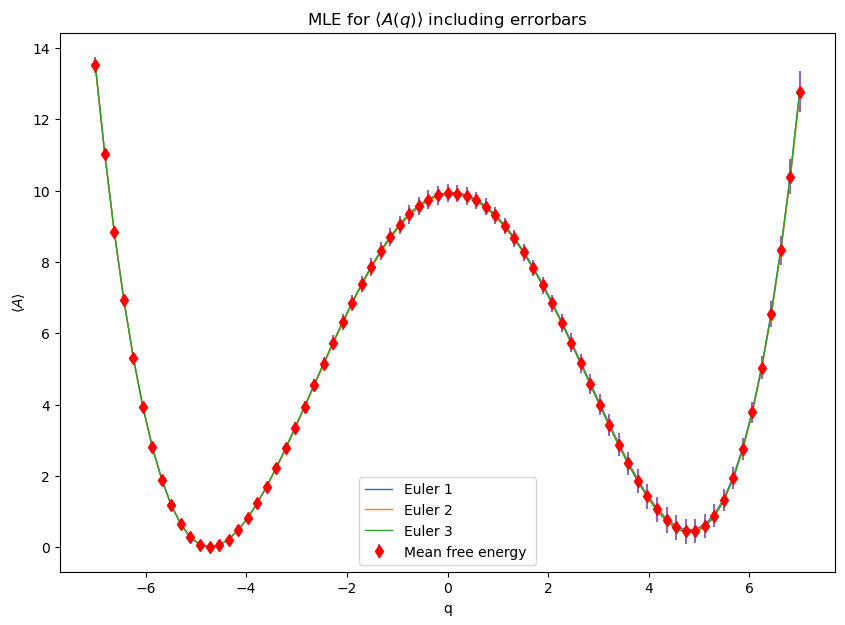

In [ ]:
# fig,xa = plt.subplots()
Euler_mean_fes=np.empty_like(Euler_fes[0])
for i in range(len(xfa)): #sum over xfa points
    sum=0
    for j in range(M):
        sum += Euler_fes[j][i]
    Euler_mean_fes[i]= sum/M

# xa.scatter(xfa,Euler_mean_fes)

Euler_var_fes=np.empty_like(xfa)
err =np.empty_like(Euler_var_fes)
for i in range(len(xfa)):
    sum=0
    for j in range(M):
        sum += (Euler_fes[j][i] - Euler_mean_fes[i])**2
    Euler_var_fes[i]= sum/(M-1)

Euler_err = np.sqrt(Euler_var_fes)
fig, ax =plt.subplots(figsize=(10,7))
ax.errorbar(xfa,Euler_mean_fes,yerr=10*Euler_err,fmt='d',color ='red', ecolor='C4',alpha=1, label="Mean free energy ")
ax.set_xlabel('q')
ax.set_ylabel('$\\langle A \\rangle$')
ax.set_title("MLE for $\\langle A (q)\\rangle$ including errorbars")


ax.plot(xfa,Euler_fes[0],label ='Euler 1',linewidth=1)
ax.plot(xfa,Euler_fes[1],label ='Euler 2',linewidth=1)
ax.plot(xfa,Euler_fes[2],label ='Euler 3',linewidth=1)
print(10*Euler_err)
ax.legend()


### Elerian training

random [2.7226118  2.64524102 2.91725852 2.37299932 2.95618183 2.52278197
 1.68613525 3.88462238]


/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: invalid value encountered in log
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: invalid value encountered in log
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: invalid value encountered in log
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: invalid value encountered in log
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)


Elerian 1 [2.7226118  2.64524102 2.91725852 2.37299932 2.95618183 2.52278197
 1.68613525 3.88462238]
random [3.88131804 4.70957306 3.05003364 2.59532259 2.45464005 1.45352268
 3.98236743 1.89893237]
Elerian 2 [3.88131804 4.70957306 3.05003364 2.59532259 2.45464005 1.45352268
 3.98236743 1.89893237]
random [1.81495347 2.7943501  4.48614836 3.23671627 1.97621486 2.2870068
 3.62524497 2.83948664]
Elerian 3 [1.81495347 2.7943501  4.48614836 3.23671627 1.97621486 2.2870068
 3.62524497 2.83948664]
Euler KM [  4.29534344 -11.47890484  11.20798964  -3.98386456   0.50554918
   0.48583757   0.50872547   0.49616769]


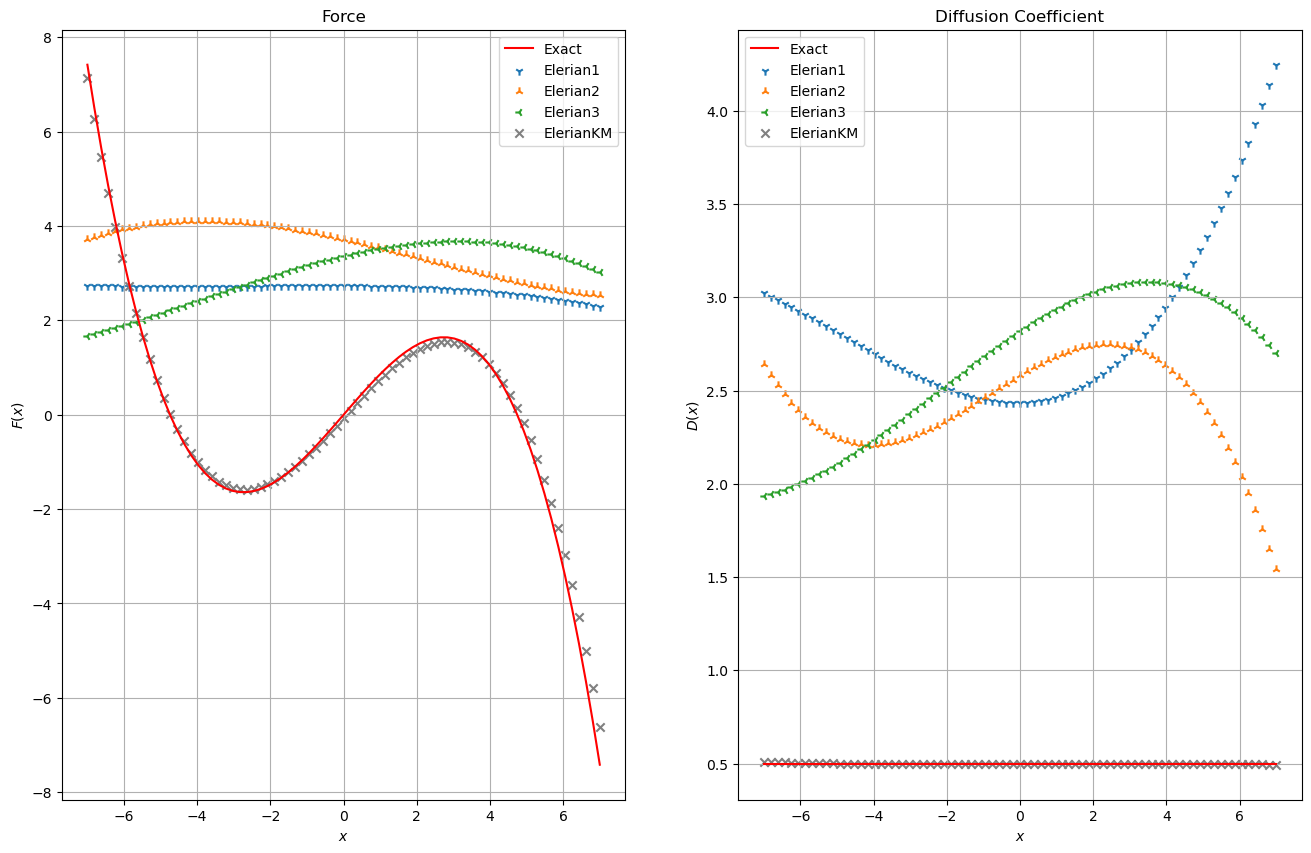

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(16,10))
np.random.seed(3)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 75)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)),color='r', label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), color='r',label="Exact")

nknots=4
domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min, data.stats.max, nknots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=None)

Elerian_res=[]
Elerian_fes=[]
markers=['1','2','3']
for index in range(M):
    coefficients0= np.random.normal(loc=mu, scale=sigma, size=2*nknots)
    print('random',coefficients0)
    estimator = fl.LikelihoodEstimator(fl.ElerianDensity(trainmodel) ,n_jobs=4)
    Elerian_res.append(estimator.fit_fetch(data,coefficients0=coefficients0))
    print('Elerian',index +1,Elerian_res[index].coefficients)
    axs[0].scatter(xfa, Elerian_res[index].force(xfa.reshape(-1, 1)), marker=markers[index], label='Elerian'+str(index+1))
    axs[1].scatter(xfa, Elerian_res[index].diffusion(xfa.reshape(-1, 1)), marker=markers[index], label='Elerian'+str(index+1))
    Elerian_fes.append(fl.analysis.free_energy_profile_1d(Elerian_res[index],xfa))
    axf.plot(xfa,Elerian_fes[index])

Elerian_res0=fl.LikelihoodEstimator(fl.EulerDensity(trainmodel) ,n_jobs=4).fit_fetch(data)
print('Euler KM',Elerian_res0.coefficients)
axs[0].scatter(xfa, Elerian_res0.force(xfa.reshape(-1, 1)),color = 'grey', marker='x', label='ElerianKM')
axs[1].scatter(xfa, Elerian_res0.diffusion(xfa.reshape(-1, 1)), color = 'grey',marker='x', label='ElerianKM')

axs[0].legend()
axs[1].legend()


#### Kessler errorbars

[41.43625311 40.76710242 40.0633626  39.32801474 38.56429788 37.77568501
 36.96585318 36.13864834 35.29804557 34.44810556 33.59292845 32.73660607
 31.88317375 31.03656281 30.20055482 29.37873851 28.57447028 27.79083885
 27.0306347  26.29632462 25.59003163 24.91352052 24.26818892 23.65506385
 23.07480385 22.5277061  22.01371856 21.53245652 21.08322315 20.66503336
 20.27664037 19.91656422 19.58312128 19.27445423 18.98856144 18.7233253
 18.47653883 18.24593009 18.02918416 17.82396234 17.62791883 17.43871453
 17.25402844 17.07156666 16.88906923 16.70431495 16.51512455 16.31936206
 16.11493481 15.89979173 15.67192031 15.42934182 15.17010485 14.89227683
 14.5939333  14.27314458 13.92795928 13.55638417 13.15635964 12.72572982
 12.26220617 11.76332305 11.22638328 10.648391   10.02596836  9.35525118
  8.63175691  7.85021561  7.00435057  6.08658933  5.08767624  3.99614311
  2.79756961  1.47352388  0.        ]


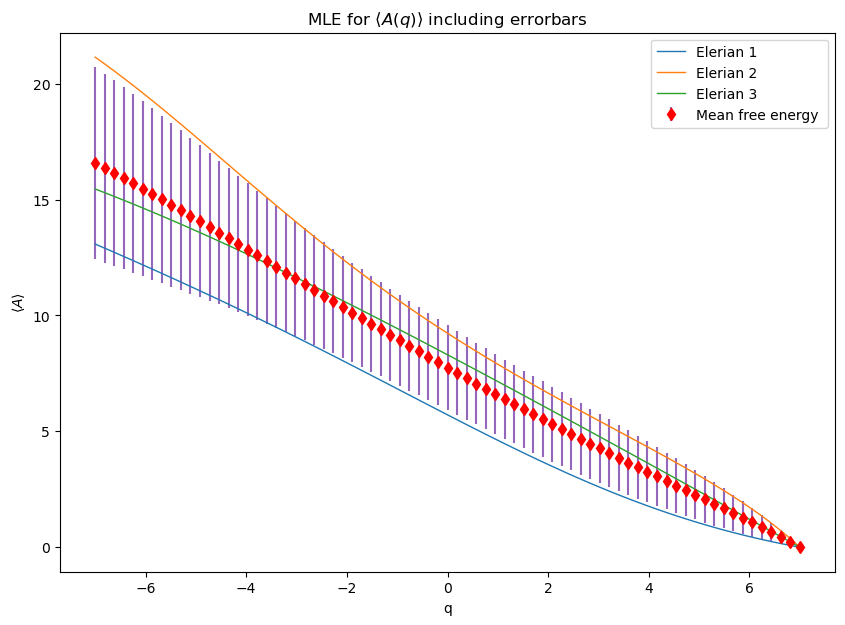

In [ ]:
# fig,xa = plt.subplots()
Elerian_mean_fes=np.empty_like(Elerian_fes[0])
for i in range(len(xfa)): #sum over xfa points
    sum=0
    for j in range(M):
        sum += Elerian_fes[j][i]
    Elerian_mean_fes[i]= sum/M

# xa.scatter(xfa,Elerian_mean_fes)

Elerian_var_fes=np.empty_like(xfa)
err =np.empty_like(Elerian_var_fes)
for i in range(len(xfa)):
    sum=0
    for j in range(M):
        sum += (Elerian_fes[j][i] - Elerian_mean_fes[i])**2
    Elerian_var_fes[i]= sum/(M-1)

Elerian_err = np.sqrt(Elerian_var_fes)
fig, ax =plt.subplots(figsize=(10,7))
ax.errorbar(xfa,Elerian_mean_fes,yerr=1*Elerian_err,fmt='d',color ='red', ecolor='C4',alpha=1, label="Mean free energy ")
ax.set_xlabel('q')
ax.set_ylabel('$\\langle A \\rangle$')
ax.set_title("MLE for $\\langle A (q)\\rangle$ including errorbars")


ax.plot(xfa,Elerian_fes[0],label ='Elerian 1',linewidth=1)
ax.plot(xfa,Elerian_fes[1],label ='Elerian 2',linewidth=1)
ax.plot(xfa,Elerian_fes[2],label ='Elerian 3',linewidth=1)
print(10*Elerian_err)
ax.legend()

### Kessler training

random [2.7226118  2.64524102 2.91725852 2.37299932 2.95618183 2.52278197
 1.68613525 3.88462238]
Kessler 1 [  4.29769219 -11.46557221  11.18486032  -3.93014948   0.5079512
   0.48342232   0.50901211   0.49751652]
random [3.88131804 4.70957306 3.05003364 2.59532259 2.45464005 1.45352268
 3.98236743 1.89893237]
Kessler 2 [  4.32283307 -11.51375622  11.20836139  -3.99325257   0.50763375
   0.48419562   0.50786314   0.49791607]
random [1.81495347 2.7943501  4.48614836 3.23671627 1.97621486 2.2870068
 3.62524497 2.83948664]
Kessler 3 [  4.32189679 -11.53476166  11.25818792  -4.00103776  -0.50759874
  -0.48429775  -0.50781331  -0.49783093]
Kessler KM [  4.29533948 -11.4789149   11.20797041  -3.98387411   0.50747718
   0.48456364   0.50759466   0.49794688]


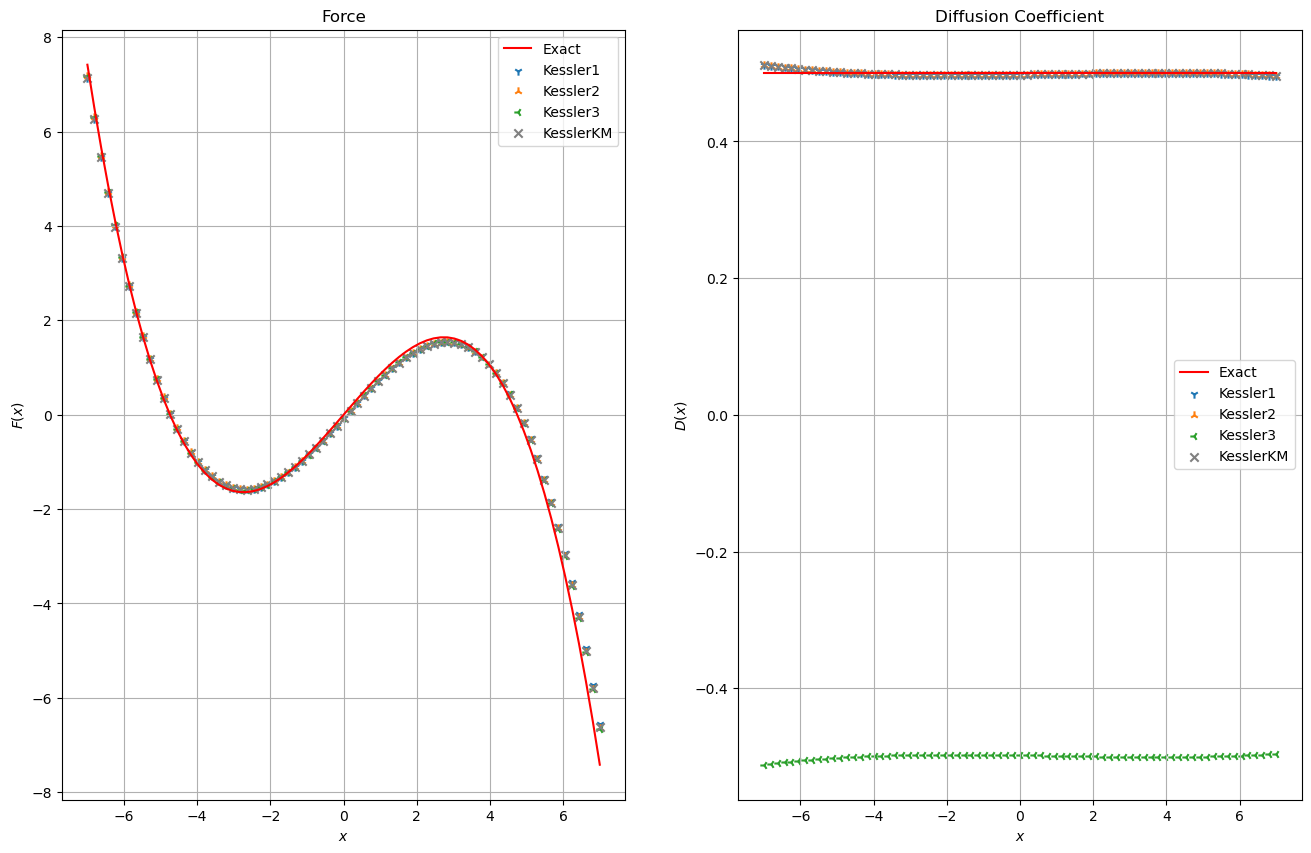

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(16,10))
np.random.seed(3)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 75)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)),color='r', label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), color='r',label="Exact")

nknots=4
domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min, data.stats.max, nknots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=None)

Kessler_res=[]
Kessler_fes=[]
markers=['1','2','3']
for index in range(M):
    coefficients0= np.random.normal(loc=mu, scale=sigma, size=2*nknots)
    print('random',coefficients0)
    estimator = fl.LikelihoodEstimator(fl.KesslerDensity(trainmodel) ,n_jobs=4)
    Kessler_res.append(estimator.fit_fetch(data,coefficients0=coefficients0))
    print('Kessler',index +1,Kessler_res[index].coefficients)
    axs[0].scatter(xfa, Kessler_res[index].force(xfa.reshape(-1, 1)), marker=markers[index], label='Kessler'+str(index+1))
    axs[1].scatter(xfa, Kessler_res[index].diffusion(xfa.reshape(-1, 1)), marker=markers[index], label='Kessler'+str(index+1))
    Kessler_fes.append(fl.analysis.free_energy_profile_1d(Kessler_res[index],xfa))
    axf.plot(xfa,Kessler_fes[index])

Kessler_res0=fl.LikelihoodEstimator(fl.KesslerDensity(trainmodel) ,n_jobs=4).fit_fetch(data)
print('Kessler KM',Kessler_res0.coefficients)
axs[0].scatter(xfa, Kessler_res0.force(xfa.reshape(-1, 1)),color = 'grey', marker='x', label='KesslerKM')
axs[1].scatter(xfa, Kessler_res0.diffusion(xfa.reshape(-1, 1)), color = 'grey',marker='x', label='KesslerKM')

axs[0].legend()
axs[1].legend()

#### Kessler errorbars

[78.12332261 49.33291425 24.09596987  2.20920761 16.57837303 32.42924494
 45.56342573 56.17893856 64.46959416 70.62445699 74.82761228 77.25797603
 78.08912226 77.48912264 75.62039702 72.63957463 68.69736535 63.93844112
 58.50132727 52.51830343 46.11531402 39.41188835 32.52107033 25.54935985
 18.59667247 11.75635765  5.1157187   1.26019121  7.26398456 12.85746776
 17.97416883 22.56108235 26.57226683 29.96863671 32.717924   34.7946619
 36.18017173 36.86254936 36.83665068 36.10407658 34.6731584  32.55894571
 29.78320042 26.37440658 22.36782194 17.80566187 12.73783128  7.22635175
  1.46514422  5.02864173 11.49257952 18.14688488 24.88678582 31.61517916
 38.2303507  44.62451172 50.68344425 56.28636828 61.30586797 65.6078341
 69.05140936 71.48893142 72.76587213 72.72077397 71.1851871  67.98361767
 62.93351434 55.84537484 46.5232616  34.76708906 20.38740823  3.71057592
 17.60478159 41.28251516 68.60922438]


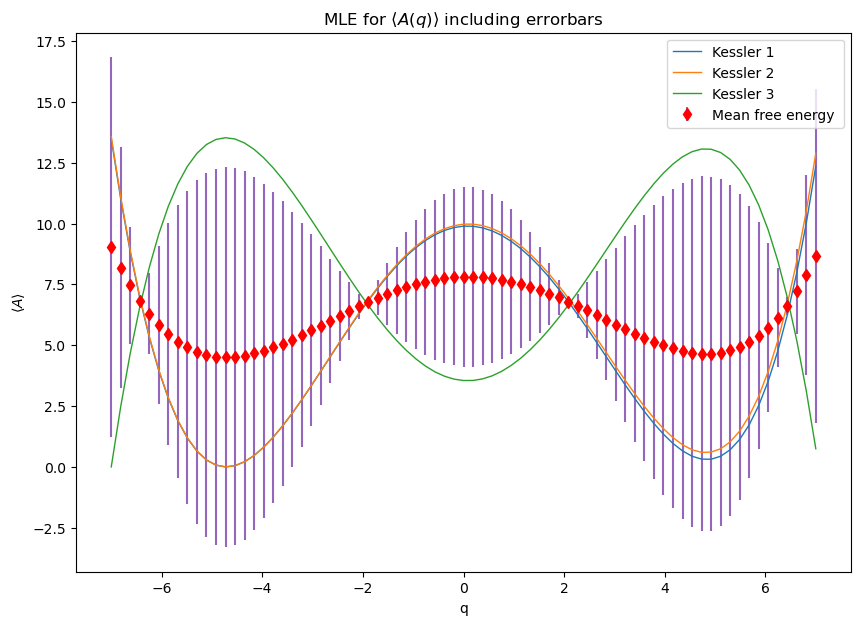

In [ ]:
# fig,xa = plt.subplots()
Kessler_mean_fes=np.empty_like(Kessler_fes[0])
for i in range(len(xfa)): #sum over xfa points
    sum=0
    for j in range(M):
        sum += Kessler_fes[j][i]
    Kessler_mean_fes[i]= sum/M

# xa.scatter(xfa,Kessler_mean_fes)

Kessler_var_fes=np.empty_like(xfa)
err =np.empty_like(Kessler_var_fes)
for i in range(len(xfa)):
    sum=0
    for j in range(M):
        sum += (Kessler_fes[j][i] - Kessler_mean_fes[i])**2
    Kessler_var_fes[i]= sum/(M-1)

Kessler_err = np.sqrt(Kessler_var_fes)
fig, ax =plt.subplots(figsize=(10,7))
ax.errorbar(xfa,Kessler_mean_fes,yerr=1*Kessler_err,fmt='d',color ='red', ecolor='C4',alpha=1, label="Mean free energy ")
ax.set_xlabel('q')
ax.set_ylabel('$\\langle A \\rangle$')
ax.set_title("MLE for $\\langle A (q)\\rangle$ including errorbars")


ax.plot(xfa,Kessler_fes[0],label ='Kessler 1',linewidth=1)
ax.plot(xfa,Kessler_fes[1],label ='Kessler 2',linewidth=1)
ax.plot(xfa,Kessler_fes[2],label ='Kessler 3',linewidth=1)
print(10*Kessler_err)
ax.legend()

### Drozdov Training

random [2.7226118  2.64524102 2.91725852 2.37299932 2.95618183 2.52278197
 1.68613525 3.88462238]
Drozdov 1 [  4.29885976 -11.48268866  11.21050415  -3.98461148   0.50757778
   0.48446794   0.50769134   0.49793126]
random [3.88131804 4.70957306 3.05003364 2.59532259 2.45464005 1.45352268
 3.98236743 1.89893237]
Drozdov 2 [  4.30617993 -11.50027224  11.22395084  -3.98901439   0.50766656
   0.48440167   0.50741667   0.49810349]
random [1.81495347 2.7943501  4.48614836 3.23671627 1.97621486 2.2870068
 3.62524497 2.83948664]
Drozdov 3 [  4.29733994 -11.48629863  11.22075773  -3.98861916   0.50744232
   0.48457759   0.50744315   0.4980571 ]
Drozdov KM [  4.29534344 -11.47890484  11.20798964  -3.98386456   0.50554918
   0.48583757   0.50872547   0.49616769]


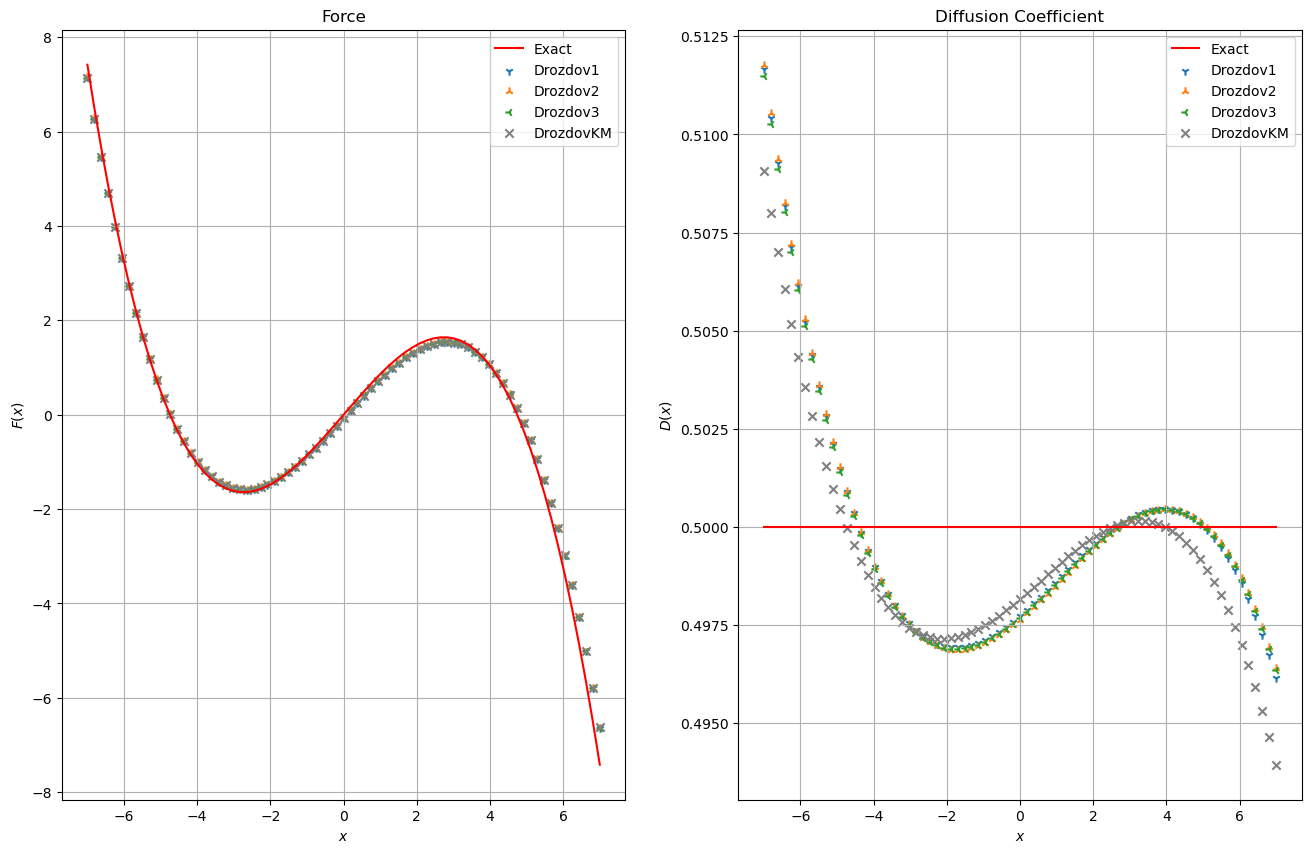

In [ ]:
#  DROZDOV
fig, axs = plt.subplots(1, 2,figsize=(16,10))
np.random.seed(3)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 75)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)),color='r', label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), color='r',label="Exact")

nknots=4
domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min, data.stats.max, nknots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=None)

Drozdov_res=[]
Drozdov_fes=[]
markers=['1','2','3']
for index in range(M):
    coefficients0= np.random.normal(loc=mu, scale=sigma, size=2*nknots)
    print('random',coefficients0)
    estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(trainmodel) ,n_jobs=4)
    Drozdov_res.append(estimator.fit_fetch(data,coefficients0=coefficients0))
    print('Drozdov',index +1,Drozdov_res[index].coefficients)
    axs[0].scatter(xfa, Drozdov_res[index].force(xfa.reshape(-1, 1)), marker=markers[index], label='Drozdov'+str(index+1))
    axs[1].scatter(xfa, Drozdov_res[index].diffusion(xfa.reshape(-1, 1)), marker=markers[index], label='Drozdov'+str(index+1))
    Drozdov_fes.append(fl.analysis.free_energy_profile_1d(Drozdov_res[index],xfa))
    axf.plot(xfa,Drozdov_fes[index])

Drozdov_res0=fl.LikelihoodEstimator(fl.EulerDensity(trainmodel) ,n_jobs=4).fit_fetch(data)
print('Drozdov KM',Drozdov_res0.coefficients)
axs[0].scatter(xfa, Drozdov_res0.force(xfa.reshape(-1, 1)),color = 'grey', marker='x', label='DrozdovKM')
axs[1].scatter(xfa, Drozdov_res0.diffusion(xfa.reshape(-1, 1)), color = 'grey',marker='x', label='DrozdovKM')

axs[0].legend()
axs[1].legend()

#### Drozdov errorbars

[0.13440707 0.11539868 0.09796827 0.08207762 0.06768697 0.05475337
 0.04322917 0.03306048 0.02418564 0.01653329 0.01002008 0.00454784
 0.         0.00376218 0.0069026  0.00961006 0.01209148 0.01455588
 0.01719125 0.02014212 0.02349758 0.02729299 0.03152113 0.03614605
 0.04111492 0.04636642 0.0518362  0.05746016 0.06317638 0.06892636
 0.07465571 0.08031468 0.08585847 0.09124748 0.09644742 0.1014295
 0.10617039 0.11065224 0.11486261 0.11879425 0.12244497 0.1258172
 0.12891769 0.13175694 0.13434862 0.13670888 0.13885561 0.14080759
 0.14258358 0.14420155 0.14567771 0.14702584 0.14825664 0.1493772
 0.15039088 0.15129723 0.1520924  0.15276975 0.15332085 0.15373678
 0.15400976 0.15413508 0.15411325 0.15395243 0.15367092 0.15329967
 0.15288462 0.15248852 0.15219197 0.15209304 0.15230494 0.15295124
 0.15415816 0.15604421 0.15870778]


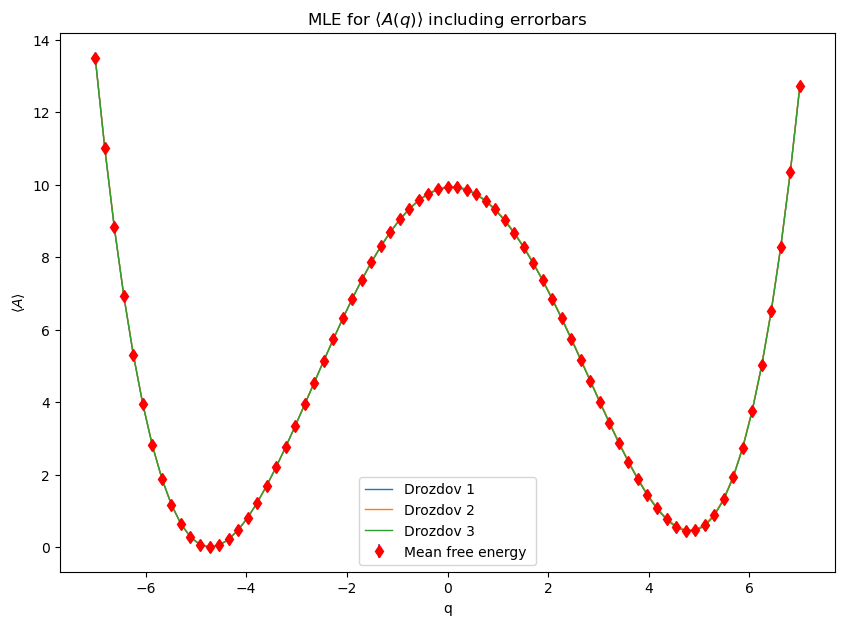

In [ ]:
# fig,xa = plt.subplots()
Drozdov_mean_fes=np.empty_like(Drozdov_fes[0])
for i in range(len(xfa)): #sum over xfa points
    sum=0
    for j in range(M):
        sum += Drozdov_fes[j][i]
    Drozdov_mean_fes[i]= sum/M

# xa.scatter(xfa,Drozdov_mean_fes)

Drozdov_var_fes=np.empty_like(xfa)
err =np.empty_like(Drozdov_var_fes)
for i in range(len(xfa)):
    sum=0
    for j in range(M):
        sum += (Drozdov_fes[j][i] - Drozdov_mean_fes[i])**2
    Drozdov_var_fes[i]= sum/(M-1)

Drozdov_err = np.sqrt(Drozdov_var_fes)
fig, ax =plt.subplots(figsize=(10,7))
ax.errorbar(xfa,Drozdov_mean_fes,yerr=1*Drozdov_err,fmt='d',color ='red', ecolor='C4',alpha=1, label="Mean free energy ")
ax.set_xlabel('q')
ax.set_ylabel('$\\langle A \\rangle$')
ax.set_title("MLE for $\\langle A (q)\\rangle$ including errorbars")


ax.plot(xfa,Drozdov_fes[0],label ='Drozdov 1',linewidth=1)
ax.plot(xfa,Drozdov_fes[1],label ='Drozdov 2',linewidth=1)
ax.plot(xfa,Drozdov_fes[2],label ='Drozdov 3',linewidth=1)
print(10*Drozdov_err)
ax.legend()